<a href="https://colab.research.google.com/github/liperdio/Autoencoder/blob/master/RestoringAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Image Restoration using Autoencoders**

The goal is to build a working model of a restoring autoencoder that will to learn a representation that is robust to any type of data corruption. 

As we feed the corrupted image as an input to the encoder part of the network, it must transform the image into a different space that would try to preserve the data set as it removes the corruption.


##Generating Corrupted Images

The input data for the model is a corrupted MNIST dataset by a white square ranging from 6.25% to 25% of the image area where the position of the white square is randomly chosen.

The corrupted images are generated from the remote repository: https://github.com/baudm/ee298z.git 

In [66]:
! git clone https://github.com/baudm/ee298z.git

fatal: destination path 'ee298z' already exists and is not an empty directory.


In [0]:
from ee298z.hw2.transforms import corrupt_mnist_copy
from ee298z.hw2.benchmark_keras import test_model

In [0]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model

In [0]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_corrupted = corrupt_mnist_copy(x_train)
x_test_corrupted = corrupt_mnist_copy(x_test)

##Visualizing the Corrupted Images



The first ten samples of the original traning data and the corrupted data are shown:

We could see that the data corruption of the white squares vary in size and position.

In [70]:
print(x_train.shape)
print(x_test.shape)
print(x_train_corrupted.shape)
print(x_test_corrupted.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28)
(10000, 28, 28)


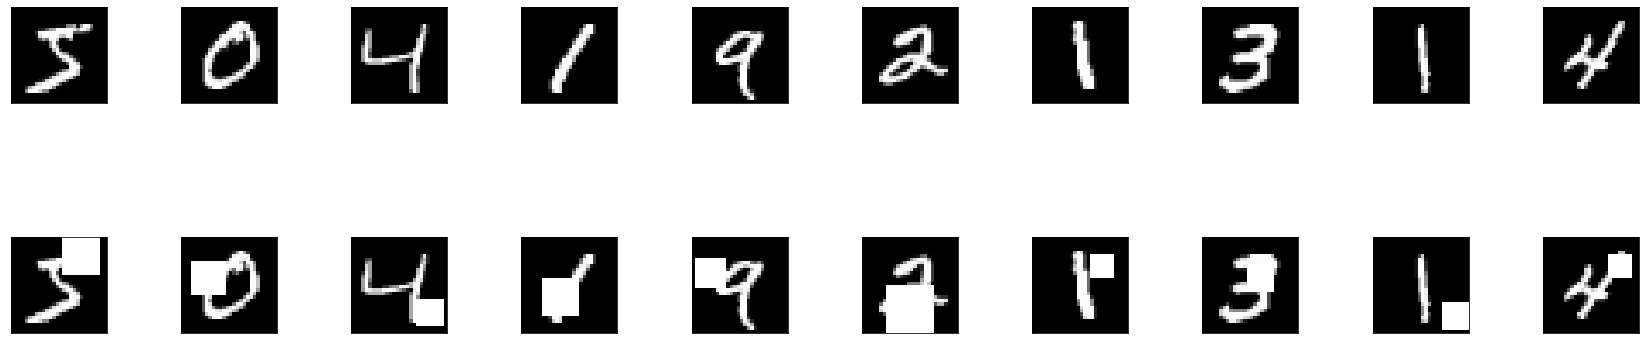

In [71]:
# Displays the first ten samples of the original train data and the corrupted data.
import matplotlib.pyplot as plt
%matplotlib inline
n = 10
plt.figure(figsize=(30,6))
for i in range(n):
  
  # original images
  ax = plt.subplot(3,n,i+1)
 
  plt.imshow(x_train[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  
  # corrupted images
  ax = plt.subplot(3,n,i+1+n*2)
  plt.imshow(x_train_corrupted[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()


Now that we have corrupted data, we can feed it into the network and see how the squares are "magically" removed from the images!

##Data Preprocessing

The images of the dataset are grayscale images with pixel values ranging from 0 to 255 having a dimension of 28 x 28. Before feeding the data into the model, we need to convert the train and test sets into matrices of size 28 x 28 x 1. 
The pixel values must also be normalized into values range of 0-1 inclusive by rescaling it with its maximum pixel value which is 255.


In [72]:
# Normalizing the input
image_size = x_train.shape[1]
# Re-shaping train data
x_train= x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
# Scaling train data from 0-1
x_train/=255
# Re-shaping test data
x_test = x_test.reshape(x_test.shape[0],28,28,1)
x_test = x_test.astype('float32')
# Scaling test data from 0-1
x_test/=255
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [73]:
# Re-shaping corrupted train data
x_train_corrupted = x_train_corrupted.reshape(x_train_corrupted.shape[0],28,28,1)
# Scaling corrupted train data from 0-1
x_train_corrupted = x_train_corrupted.astype(K.floatx()) / 255.

# Re-shaping corrupted test data
x_test_corrupted = x_test_corrupted.reshape(x_test_corrupted.shape[0],28,28,1)
# Scaling corrupted test data from 0-1
x_test_corrupted = x_test_corrupted.astype(K.floatx()) / 255.

print(x_train_corrupted.shape)
print(x_test_corrupted.shape)


(60000, 28, 28, 1)
(10000, 28, 28, 1)


##Network Parameters

The batch size used was 32, as I train my network for 10 epochs.

In [0]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
epochs = 10
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 64]

##Autoencoder Model

###Encoder Model

The first layer will have 32 filters of size 14 x 14.

The second layer will have 64 filters of size 7 x 7 followed by a flatten layer to reshape the tensor into its channel dimension.

In [0]:
# Autoencoder model
# Encoder Model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs

In [0]:
# stack of Conv2D(32)-Conv2D(64)
for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)

In [0]:
# the input to the decoder's first Conv2DTranspose will have this shape
# shape is (7, 7, 64) which can be processed by the decoder back to (28, 28, 1)
shape = K.int_shape(x)

In [0]:
# generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [79]:
# instantiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten_4 (Flatten)          (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


###Decoder Model

The input to the decoder model must be reshaped first to become suitable shape for transpose conv.

The first layer will have 64 filters of size 14 x 14.

The second layer will have 32 filters of size 28 x 28.

Then the final layer of the decoder will have 1 filter of size 28 x 28.

In [0]:
# Decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
# from vector to suitable shape for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)


In [0]:
# stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

In [0]:
# reconstruct the denoised input
outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          padding='same',
                          activation='sigmoid',
                          name='decoder_output')(x)


In [83]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3136)              53312     
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [84]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
encoder (Model)              (None, 16)                69008     
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


##Autoencoder Compiler

After the model is created, we have to compile it using an optimizer RMSProp and a specified loss type which is the MSE (Mean squared error). MSE will be computed for the loss between the batch of predicted output and the ground truth pixel by pixel.

In [0]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')


##Train the Model

At every iteration of the training, the network will compute a loss between the corrupted image outputted by the decoder, and the ground truth (original MNIST), and will try to minimize the loss or difference between the reconstructed image and the original noise-free image.

In [86]:
# Train the autoencoder
autoencoder_train = autoencoder.fit(x_train_corrupted,
                x_train,
                validation_data=(x_test_corrupted, x_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 108s 2ms/step - loss: 0.0358 - val_loss: 0.0221
Epoch 2/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0205 - val_loss: 0.0191
Epoch 3/10
60000/60000 [==============================] - 108s 2ms/step - loss: 0.0187 - val_loss: 0.0182
Epoch 4/10
60000/60000 [==============================] - 108s 2ms/step - loss: 0.0177 - val_loss: 0.0176
Epoch 5/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0170 - val_loss: 0.0172
Epoch 6/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0165 - val_loss: 0.0168
Epoch 7/10
60000/60000 [==============================] - 110s 2ms/step - loss: 0.0162 - val_loss: 0.0166
Epoch 8/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 9/10
60000/60000 [==============================] - 109s 2ms/step - loss: 0.0156 - val_loss: 0.0

##Training vs Validation Loss Plot

Finally, we can see that the validation loss and the training loss both are in sync. 

It is shown that our model is not overfitting, as the validation loss is decreasing, and there rarely any gap between the training and validation loss.



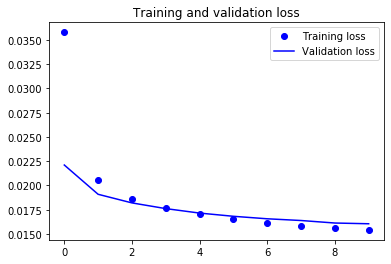

In [87]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
#epochs = epochs
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

##Benchmark

The benchmark code is generated from the remote repository: https://github.com/baudm/ee298z.git

It consists of two metrics; the Classifier Score and the SSIM Score.

The Classifier Score measures the quality of inpainting and has a baseline value of 78.13(for PyTorch) and 78.36 (for Keras).

On the otherhand, the SSIM Score measures the capability to detect and preserve uncorrupted pixels having a baseline value of 75.



In [89]:
from tensorflow.keras.datasets import mnist 
from tensorflow.keras import backend as K 
from ee298z.hw2.benchmark_keras import test_model 
(x_train, y_train), (x_bench, y_bench) = mnist.load_data() 
# Scale to [0, 1] 
x_bench = x_bench.astype(K.floatx()) / 255. 
# model is your Keras model # DO NOT convert y_bench, i.e. don't use keras.utils.to_categorical() 
test_model(autoencoder, x_bench, y_bench, batch_size=100)


Classifier score: 93.92
SSIM score: 89.69


The scores that our model generated were higher than the baseline scores which indicates that our model's generalization capability is good.

##Predicting on Test Data

Finally, we must see how well our model is able to reconstruct on the test data.

We will be predicting the trained model on the complete 10,000 images using the Keras predict() function. 

In [90]:
# run noisy test data through the encoder
print(x_test_corrupted.shape)
encoded_imgs = encoder.predict(x_test_corrupted)
print(encoded_imgs.shape)
# run encoded noisy test image back through the decoder
decoded_imgs = decoder.predict(encoded_imgs)

# make sense of the shapes

print(decoded_imgs.shape)

(10000, 28, 28, 1)
(10000, 16)
(10000, 28, 28, 1)


Here are the sample reconstructed images to visualize how well our model is able to construct the test images.

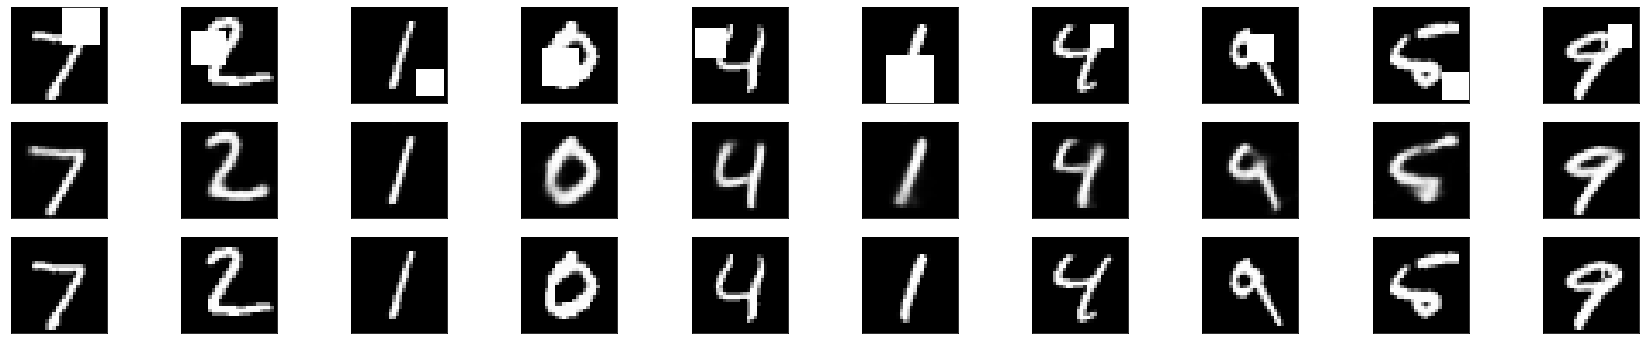

In [91]:
# display the images
n = 10
plt.figure(figsize=(30,6))
for i in range(n):
  # noisy images
  ax = plt.subplot(3,n,i+1)
  plt.imshow(x_test_corrupted[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # denoised images
  ax = plt.subplot(3,n,i+1+n)
  plt.imshow(decoded_imgs[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # original images
  ax = plt.subplot(3,n,i+1+n*2)
  plt.imshow(x_test[i].reshape(28,28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


First row : Corrupted Image Samples

Second row : Reconstructed Image Samples

Third row : Original Image Samples (Ground Truth)

From the above figures, We can observe that those blurry parts of the reconstructed images are the locations of the white squares on the corrupted images. 

We can also observe that our model did a fantastic job in reconstructing the test images that we predicted using the model. 

##Conclusion

As we corrupt the input data using white squares generation, we have learned about that data by attempting to reconstruct it. The job of the autoencoder network is to recognize the features within the squares that will allow it to classify the input. 

While the network is being trained, it generates a model, then measures the distance between the model and the benchmark through a loss function. Furthermore, it attempts to minimize that loss function by resampling and reconstructing the data again, until it finds those inputs that would bring the model closest to the ground truth. 